# Generate Figures for Manuscript


# Setup

In [1]:
## Load packages
import grama as gr
import numpy as np
import pandas as pd
%matplotlib inline

## Load scikit tools
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

## Package setup
DF = gr.Intention()

## Helper Functions

In [2]:
## Barycentric converter
def tran_bary(df, a="I", b="Br", c="Cl", x="x", y="y"):
    r"""Convert to barycentric coordinates
    """
    df_tmp = df.copy()
    df_tmp[x] = 0.0 * df[a] + 1.0 * df[b] + 0.5 * df[c]
    df_tmp[y] = 0.0 * df[a] + 0.0 * df[b] + np.sqrt(1 - 0.5**2) * df[c]
    
    return df_tmp

## Inverse transform
def tran_thp(df, x="x", y="y", a="I", b="Br", c="Cl"):
    df_tmp = df.copy()
    xa = 0; ya = 0
    xb = 1; yb = 0
    xc = 0.5; yc = np.sqrt(1 - 0.5**2)
    d = (yb - yc) * (xa - xc) + (xc - xb) * (ya - yc)
    df_tmp[a] = ((yb - yc) * (df_tmp[x] - xc) + (xc - xb) * (df_tmp[y] - yc)) / d
    df_tmp[b] = ((yc - ya) * (df_tmp[x] - xc) + (xa - xc) * (df_tmp[y] - yc)) / d
    df_tmp[c] = 1 - df_tmp[a] - df_tmp[b]

    return df_tmp

# Pipe-enabled functions
tf_bary = gr.add_pipe(tran_bary)
tf_thp = gr.add_pipe(tran_thp)

## Metadata


In [3]:
# Triangle boundary
df_tri_bounds = (
    gr.df_make(
        Br=[1, 0, 0, 1],
        Cl=[0, 1, 0, 0],
        I =[0, 0, 1, 0],
    )
    >> tf_bary()
)

# Labels
df_tri_labels = (
    gr.df_make(
        x=[-0.1, +1.1, +0.5],
        y=[+0.0, +0.0, +np.sqrt(1 - 0.5**2) + 0.1],
        label=["I", "Br", "Cl"]
    )
)

# Guidelines
df_tri_guides = (
    gr.df_make(
        Br_0=[0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25],
        Br_1=[0.25, 0.5, 0.75, 0.00, 0.0, 0.00, 0.00, 0.0, 0.00],
        Cl_0=[0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.00, 0.0, 0.00],
        Cl_1=[0.00, 0.0, 0.00, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25],
        I_0 =[0.00, 0.0, 0.00, 0.00, 0.0, 0.00, 0.25, 0.5, 0.75],
        I_1 =[0.75, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75],
    )
    >> tf_bary(a="I_0", b="Br_0", c="Cl_0")
    >> tf_bary(a="I_1", b="Br_1", c="Cl_1", x="xend", y="yend")
)

## Load measurements

In [4]:
df_data = (
    pd.read_csv("./Data/measurements.csv")
    >> gr.tf_bind_rows(
        pd.read_csv("./Data/measurements-round3-corrected.csv")
        >> gr.tf_rename(round="Round")
    )
    >> gr.tf_arrange(DF["round"])
)
df_data

,Cl,I,Br,single_phase,round
0,1.000000,0.000000,0.000000,True,0
1,0.000000,1.000000,0.000000,True,0
2,0.000000,0.000000,1.000000,True,0
3,0.000000,0.500000,0.500000,True,1
4,0.500000,0.000000,0.500000,True,1
5,0.500000,0.500000,0.000000,False,1
6,0.330000,0.330000,0.340000,True,1
7,0.600000,0.280000,0.120000,False,2
8,0.710000,0.240000,0.050000,False,2
9,0.350000,0.500000,0.150000,False,2


# Generate Figures


## Tolerance factor contour plot


/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./images/ternary-tolerance.png
/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.
/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


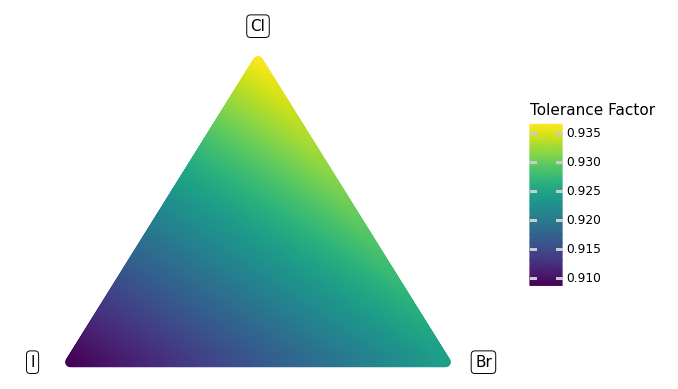

<ggplot: (8762338359459)>

In [5]:
## Define helper function
@gr.make_symbolic
def tolerance(a, b, x):
    r"""Calculate Goldschmidt tolerance factor
    
    Calculates the Goldschmidt tolerance factor for a perovskite structure.
    
    Arguments:
        a (float): Atomic radius, A cation
        b (float): Atomic radius, B cation
        x (float): Atomic radius, anion
    
    Returns:
        float: Goldschmidt tolerance factor
    """
    return (a + x) / ( gr.sqrt(2) * (b + x) )

## Define atomic radii
# Cations
Pb_R = 0.119 # Shannon radii
Cs_R = 0.216 # Shannon radii 

# Anions
I_R  = 0.22  # Shannon radii
Br_R = 0.197 # Shannon radii
Cl_R = 0.181 # Shannon radii

## Generate data
n_res = 500 # 500 for smooth plot
df_tolerance = (
    # Build a grid of values; will include invalid compositions
    gr.df_grid(
        I=gr.linspace(0, 1, n_res),
        Br=gr.linspace(0, 1, n_res),
    )
    # Compute Cl from ternary relationship
    >> gr.tf_mutate(Cl=1 - DF.I - DF.Br)
    # Take weighted sum of radii
    >> gr.tf_mutate(
        eff_R = Cl_R * DF.Cl
              + Br_R * DF.Br
              + I_R  * DF.I,
    )
    # Compute tolerance factor
    >> gr.tf_mutate(tol=tolerance(Cs_R, Pb_R, DF.eff_R))
    # Filter to valid compositions only
    >> gr.tf_filter(
        0 <= DF.Cl,
        DF.Cl <= 1
    )
)

## Visualize
p = (
    df_tolerance
    >> tf_bary()
    
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Data
    + gr.geom_point(
        gr.aes(color="tol"), 
        size=3,
    )
    # Plot tail
    + gr.scale_color_continuous(
        name="Tolerance Factor",
        # limits=(0.85, 0.90), # Limits emphasize tolerance factor < 0.9
    )
    + gr.theme_void()
    + gr.theme(
        # legend_position="bottom",
        plot_background=gr.element_rect(fill="white")
    )
    
)
p.save("./images/ternary-tolerance.png")
p

[Wikipedia](https://en.wikipedia.org/wiki/Goldschmidt_tolerance_factor) gives values for the tolerance factor $t$ that correspond to particular perovskite structures:

| $t$ | Structure | Explanation |
|-----|-----------|-------------|
| $1 < t$ | Hexagonal or Tetragonal | A ion too big or B ion too small |
| $0.9 \leq t \leq 1$ | Cubic | A and B ions of ideal size |
| $0.71 \leq t \leq 0.9$ | Orthorhombic / Rhombohedral | A ions too small to fit into B ion interstices |
| $t < 0.71$ | Differenet structures | A and B ions have similar radii |

I'm not sure how to interpret these rules-of-thumb in our context; do we only want Cubic perovskites (in which case, the tolerance factor predicts all compositions fail), or do we want *any* perovskites (in which case, the tolerance factor predicts all compositions are single-phase)?

Shannon Radius: method of estimating the ionic radius of an ion
- there's essentially "pressure" that electrons exert on a radius, so adding/subtracting an electron from an atom will change its' nucleus' radius
- based on systematic, empirical review by [Shannon 1976](http://scripts.iucr.org/cgi-bin/paper?S0567739476001551)

Updates (2022-08-18)
- The tolerance factor calculation should use MA rather than Cs
- Our goal is for a cubic perovskite structure; thus the goal range is $0.9 \leq t \leq 1.0$.
- Empirically, $t$ closer to 1 tends to be more stable
  - tends to prevent infiltration of water (and other) into the lattice
- There exists an updated tolerance factor ($\tau$) that seeks to correct the limitations of $t$.


## Initial data


/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./images/initial-data.png
/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.
/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


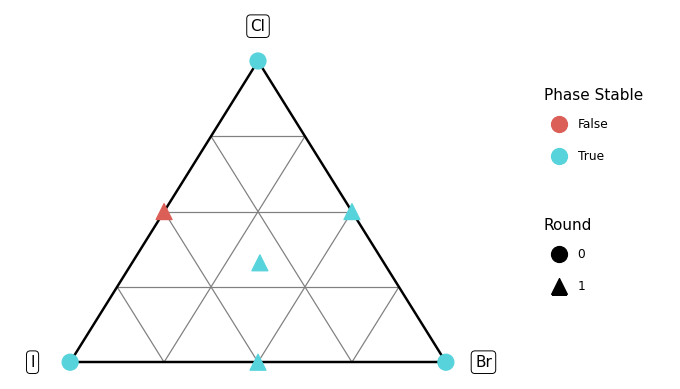

<ggplot: (8762361331447)>

In [6]:
p = (
    df_data
    >> gr.tf_filter(DF["round"] <= 1)
    >> tf_bary()
    
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Data
    + gr.geom_point(
        gr.aes(color="single_phase", shape="factor(round)"), 
        size=6,
    )
    # Plot tail
    + gr.scale_color_discrete(name="Phase Stable")
    + gr.scale_shape_discrete(name="Round")
    + gr.theme_void()
    + gr.theme(
        # legend_position="bottom",
        plot_background=gr.element_rect(fill="white")
    )
)
p.save("./images/initial-data.png")
p

## Primary ternary figure


/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./images/ternary-data.png
/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.
/Users/zach/opt/anaconda3/envs/grama/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


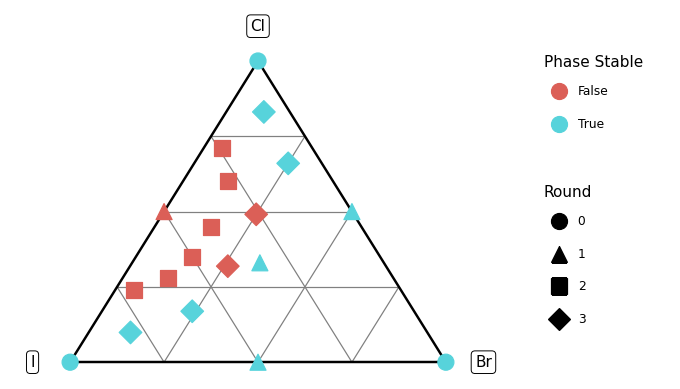

<ggplot: (8762338546300)>

In [7]:
p = (
    df_data
    >> tf_bary()
    
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Data
    + gr.geom_point(
        gr.aes(color="single_phase", shape="factor(round)"), 
        size=6,
    )
    # Plot tail
    + gr.scale_color_discrete(name="Phase Stable")
    + gr.scale_shape_discrete(name="Round")
    + gr.theme_void()
    + gr.theme(
        # legend_position="bottom",
        plot_background=gr.element_rect(fill="white")
    )
)
p.save("./images/ternary-data.png")
p

# Fit model


In [8]:
md_fit = (
    df_data
    >> tf_bary
    >> gr.ft_gp(
        out=["single_phase"],
        var=["x", "y"],
        # kernels=dict(single_phase=Matern(length_scale=0.5, nu=0.5)), # continuous
        kernels=dict(single_phase=Matern(length_scale=0.1, nu=1.5)), # once-differentiable
        # kernels=dict(single_phase=Matern(length_scale=0.5, nu=2.5)), # twice-differentiable
        # kernels=dict(single_phase=Matern(length_scale=0.5, nu=np.inf)), # infinitely-differentiable
        seed=103,
    )
)

md_fit

model: (no name)

  inputs:
    var_det:
      x: (unbounded)
      y: (unbounded)

    var_rand:


    copula:
      None

  functions:
      GP (Matern(length_scale=0.113, nu=1.5)): ['x', 'y'] -> ['single_phase_mean', 'single_phase_sd']

In [9]:
(
    md_fit
    >> gr.ev_df(gr.df_grid(x=[0.25, 0.5, 0.75], y=[0.25, 0.5, 0.75]))
)

,x,y,single_phase_mean,single_phase_sd
0,0.25,0.25,-0.040641,0.087301
1,0.50,0.25,0.912561,0.238035
2,0.75,0.25,0.697914,0.489354
3,0.25,0.50,0.112537,0.361398
4,0.50,0.50,0.239093,0.297463
5,0.75,0.50,0.903112,0.365100
6,0.25,0.75,0.483173,0.492015
7,0.50,0.75,0.987031,0.219450
8,0.75,0.75,0.651759,0.493979


## Assess ML model via contours


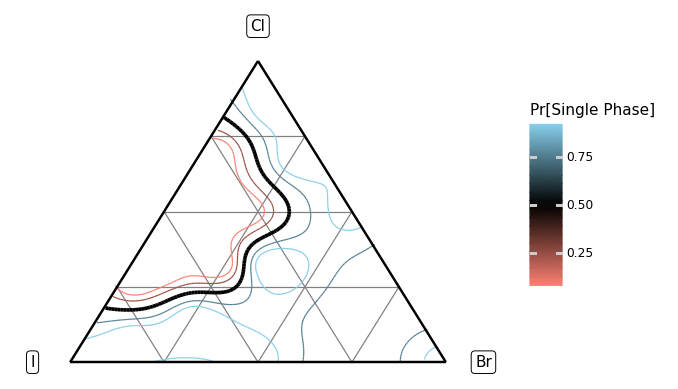

<ggplot: (8762361458451)>

In [10]:
df_contours = (
    md_fit
    >> gr.cp_bounds(x=(0, 1), y=(0, 1))
    >> gr.ev_contour(
        out=["single_phase_mean"], 
        var=["x", "y"], 
        n_side=128,
        levels=dict(single_phase_mean=[0.1, 0.25, 0.5, 0.75, 0.9])
    )
    >> tf_thp()
    >> gr.tf_filter(
        0 <= DF.I,
        0 <= DF.Br,
        0 <= DF.Cl,
        DF.I <= 1,
        DF.Br <= 1,
        DF.Cl <= 1,
    )
)

p = (
    df_contours
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Data
    + gr.geom_segment(
        gr.aes(xend="x_end", yend="y_end", color="level"), 
        size=0.5,
    )
    + gr.geom_segment(
        data=df_contours
        >> gr.tf_filter(DF.level == 0.5),
        mapping=gr.aes(xend="x_end", yend="y_end", color="level"), 
        size=1.5
    )
    # Triangle border
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    # Plot tail
    # + gr.scale_color_continuous(name="Pr[Single Phase]")
    + gr.scale_color_gradient2(
        name="Pr[Single Phase]",
        high="skyblue",
        mid="black",
        low="salmon",
        midpoint=0.5,
    )
    + gr.theme_void()
    + gr.theme(
        # legend_position="bottom",
        plot_background=gr.element_rect(fill="white")
    )
    
)
p.save("./images/ternary-contours.png")
p

## ML Phase Boundary


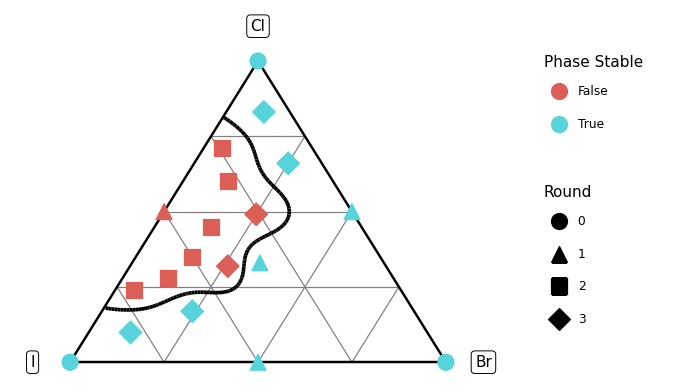

<ggplot: (8762338442608)>

In [11]:
df_contours = (
    md_fit
    >> gr.cp_bounds(x=(0, 1), y=(0, 1))
    >> gr.ev_contour(
        out=["single_phase_mean"], 
        var=["x", "y"], 
        n_side=128,
        levels=dict(single_phase_mean=[0.5])
    )
    >> tf_thp()
    >> gr.tf_filter(
        0 <= DF.I,
        0 <= DF.Br,
        0 <= DF.Cl,
        DF.I <= 1,
        DF.Br <= 1,
        DF.Cl <= 1,
    )
)

p = (
    df_contours
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Data
    + gr.geom_segment(
        data=df_contours
        >> gr.tf_filter(DF.level == 0.5),
        mapping=gr.aes(xend="x_end", yend="y_end"), 
        size=1.5,
        color="black",
    )
    # Triangle border
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    + gr.geom_point(
        data=df_data
        >> tf_bary(),
        mapping=gr.aes(color="single_phase", shape="factor(round)"), 
        size=6,
    )
    # Plot tail
    + gr.scale_color_discrete(name="Phase Stable")
    + gr.scale_shape_discrete(name="Round")
    + gr.theme_void()
    + gr.theme(
        # legend_position="bottom",
        plot_background=gr.element_rect(fill="white")
    )
    
)
p.save("./images/ternary-boundary.png")
p

# Boundary Indicators


In [12]:
df_boundary_raw = pd.read_csv("./XRD_Data/Processed Results.csv")

df_boundary = (
    df_boundary_raw
    >> gr.tf_left_join(
        df_data
        >> gr.tf_mutate(
            Cl=gr.round(DF.Cl, decimals=2),
            I=gr.round(DF.I, decimals=2),
            Br=gr.round(DF.Br, decimals=2),
        ),
        by=["Cl", "I", "Br"],
    )
)
df_boundary 

,Unnamed: 0,Chemistry,Cl,I,Br,Predicted Lattice,[100],[110],[200],[012],Lattice 1,Lattice 2,Delta,FWHM,single_phase,round
0,0,1.0,0.10,0.79,0.11,6.189745,14.297732,20.273216,28.824330,32.314397,6.265299,0.000000,312.027296,0.447330,True,3
1,1,2.0,0.66,0.09,0.25,5.796186,15.274148,21.665855,30.828453,34.575219,5.790178,0.000000,528.512101,0.408298,True,3
2,2,3.0,0.83,0.07,0.10,5.749627,15.398579,21.843444,31.084371,34.864127,5.738117,0.000000,985.178206,0.427516,True,3
3,3,4.0,0.17,0.59,0.24,6.097984,14.514030,20.581580,29.267679,32.814287,6.130976,0.000000,903.334853,0.419723,True,3
4,4,5.0,0.32,0.42,0.26,5.999566,14.753436,20.922977,29.758790,33.368191,6.139111,5.871681,548.328035,1.151725,False,3
5,5,6.0,0.49,0.26,0.25,5.899074,15.006198,21.283524,30.277763,33.953706,5.837077,0.000000,324.736483,0.420340,False,3
6,6,7.0,0.00,0.50,0.50,6.102000,14.504428,20.567889,29.247989,32.792083,6.142555,0.000000,854.301460,0.426022,True,1
7,7,8.0,0.50,0.00,0.50,5.798500,15.268016,21.657103,30.815842,34.560984,5.853710,0.000000,795.500894,0.406738,True,1
8,8,9.0,0.50,0.50,0.00,5.988500,14.780850,20.962076,29.815054,33.431660,5.721404,6.315139,304.765594,0.471038,False,1
9,9,10.0,0.33,0.33,0.34,5.962490,14.845691,21.054559,29.948153,33.581811,5.952187,0.000000,2740.424295,0.530892,True,1


## Delta


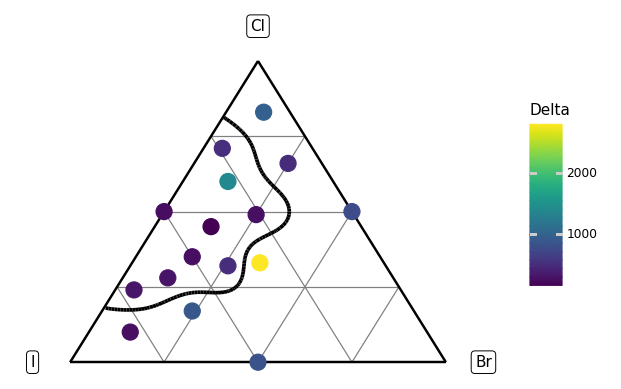

<ggplot: (8762361415735)>

In [13]:
p = (
    df_boundary
    >> tf_bary()
    
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Fitted contour
    + gr.geom_segment(
        data=df_contours
        >> gr.tf_filter(DF.level == 0.5),
        mapping=gr.aes(xend="x_end", yend="y_end"), 
        color="black",
        size=1.5,
    )
    # Data
    + gr.geom_point(
        gr.aes(color="Delta"), 
        size=6,
    )
    # Plot tail
    + gr.theme_void()
    + gr.theme(
        # legend_position="bottom",
        plot_background=gr.element_rect(fill="white")
    )
)
p.save("./images/ternary-boundary-delta.png")
p

## FWHM


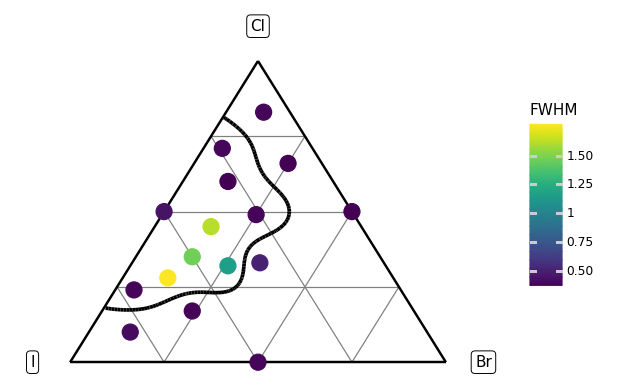

<ggplot: (8762371197085)>

In [14]:
p = (
    df_boundary
    >> tf_bary()
    
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Fitted contour
    + gr.geom_segment(
        data=df_contours
        >> gr.tf_filter(DF.level == 0.5),
        mapping=gr.aes(xend="x_end", yend="y_end"), 
        color="black",
        size=1.5,
    )
    # Data
    + gr.geom_point(
        gr.aes(color="FWHM"), 
        size=6,
    )
    # Plot tail
    + gr.theme_void()
    + gr.theme(
        # legend_position="bottom",
        plot_background=gr.element_rect(fill="white")
    )
)
p.save("./images/ternary-boundary-fwhm.png")
p

# Sequential DOE: Univariate Cartoon

## Model setup


In [15]:
md_multi = (
    gr.Model("Multi-modal surface") 
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            f=gr.sin(1.5 * np.pi * df.x) + df.x**2,
        ),
        var=["x"],
        out=["f"],
    )
    >> gr.cp_bounds(x=(-3, +3))
)
md_multi

model: Multi-modal surface

  inputs:
    var_det:
      x: [-3, 3]

    var_rand:

    copula:
      None

  functions:
      f0: ['x'] -> ['f']

Calling plot_sinew_outputs....


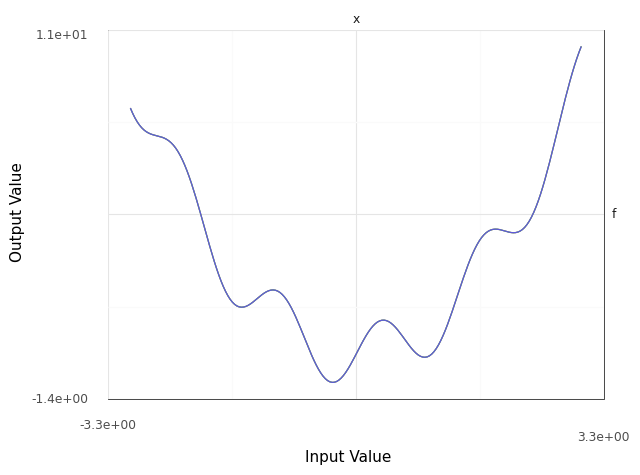

<ggplot: (8762371571276)>

In [16]:
(
    md_multi
    >> gr.ev_sinews(df_det="swp", n_density=200)
    >> gr.pt_auto()
)

## Round 0 - No Model


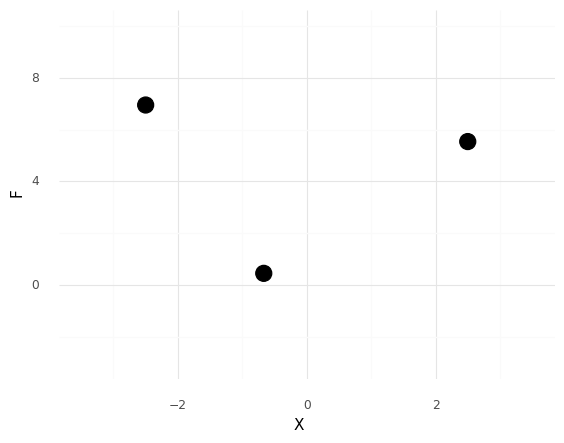

<ggplot: (8762371129236)>

In [26]:
df_init = gr.eval_df(
    md_multi,
    df=gr.df_make(x=[-2.5, -2/3, +2.5]),
)

p = (
    df_init
    >> gr.ggplot(gr.aes("x", "f"))
    + gr.geom_point(size=6)
    + gr.scale_x_continuous(limits=(-3.5, +3.5))
    + gr.scale_y_continuous(limits=(-3.0, 10))
    + gr.theme_minimal()
    + gr.theme(panel_background=gr.element_rect(fill="white"))
    + gr.labs(
        x="X",
        y="F",
    )
)
p.save("./images/sdoe-round0-nofit.png")
p

## Round 0 - Fitted Model


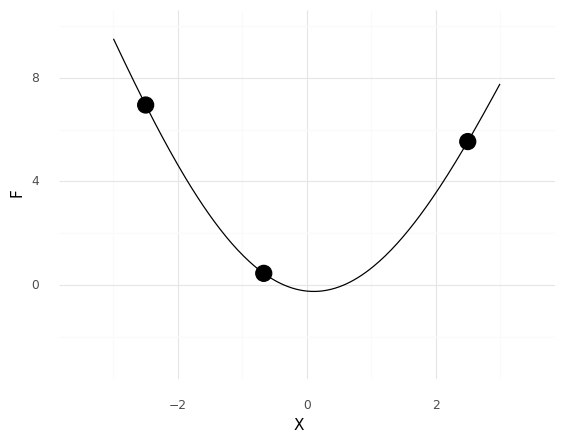

<ggplot: (8762371585214)>

In [18]:
## Fit a model
md_fit0 = (
    df_init
    >> gr.ft_gp(
        var=["x"],
        out=["f"],
    )
    >> gr.cp_bounds(x=(-3, +3))
)

p = (
    df_init
    >> gr.ggplot(gr.aes("x", "f"))
    
    + gr.geom_line(
        data=md_fit0
        >> gr.ev_df(df=gr.df_make(x=gr.linspace(-3, +3, 200))),
        mapping=gr.aes(y="f_mean"),
    )
    + gr.geom_point(size=6)
    
    + gr.scale_x_continuous(limits=(-3.5, +3.5))
    + gr.scale_y_continuous(limits=(-3.0, 10))
    + gr.theme_minimal()
    + gr.theme(panel_background=gr.element_rect(fill="white"))
    + gr.labs(
        x="X",
        y="F",
    )
)
p.save("./images/sdoe-round0.png")
p

## Round 0 - Minimized Model


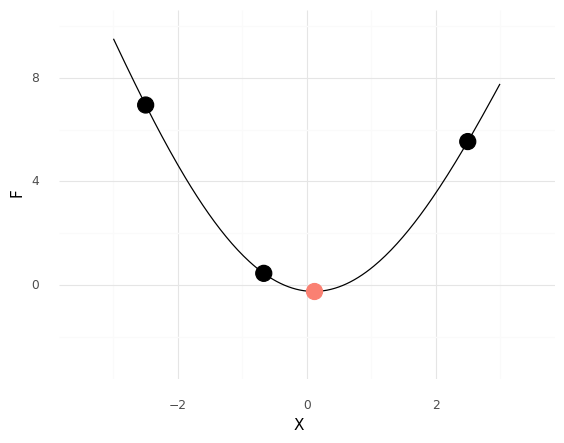

<ggplot: (8762338855394)>

In [19]:
## Minimize the fitted model
df_opt0 = (
    md_fit0
    >> gr.ev_min(
        out_min="f_mean",
    )
)

## Vis
p = (
    df_init
    >> gr.ggplot(gr.aes("x", "f"))
    
    + gr.geom_line(
        data=md_fit0
        >> gr.ev_df(df=gr.df_make(x=gr.linspace(-3, +3, 200))),
        mapping=gr.aes(y="f_mean"),
    )
    + gr.geom_point(size=6)
    + gr.geom_point(
        data=df_opt0,
        mapping=gr.aes(y="f_mean"),
        size=6,
        color="salmon",
    )
    
    + gr.scale_x_continuous(limits=(-3.5, +3.5))
    + gr.scale_y_continuous(limits=(-3.0, 10))
    + gr.theme_minimal()
    + gr.theme(panel_background=gr.element_rect(fill="white"))
    + gr.labs(
        x="X",
        y="F",
    )
)
p.save("./images/sdoe-round0-opt.png")
p

## Round 1 - Evaluated

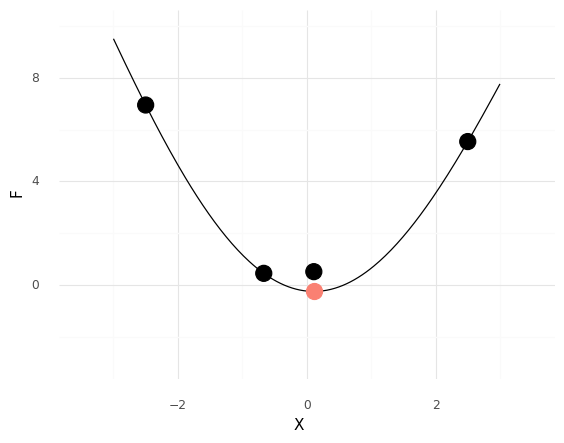

<ggplot: (8762371391263)>

In [20]:
## Minimize the fitted model
df_round1 = (
    df_init
    >> gr.tf_bind_rows(
        md_multi
        >> gr.ev_df(df_opt0),
    )
)

## Vis
p = (
    df_round1
    >> gr.ggplot(gr.aes("x", "f"))
    
    + gr.geom_line(
        data=md_fit0
        >> gr.ev_df(df=gr.df_make(x=gr.linspace(-3, +3, 200))),
        mapping=gr.aes(y="f_mean"),
    )
    + gr.geom_point(
        data=df_opt0,
        mapping=gr.aes(y="f_mean"),
        size=6,
        color="salmon",
    )
    + gr.geom_point(size=6)
    
    + gr.scale_x_continuous(limits=(-3.5, +3.5))
    + gr.scale_y_continuous(limits=(-3.0, 10))
    + gr.theme_minimal()
    + gr.theme(panel_background=gr.element_rect(fill="white"))
    + gr.labs(
        x="X",
        y="F",
    )
)
p.save("./images/sdoe-round1-eval.png")
p

## Round 1 - Fitted Model

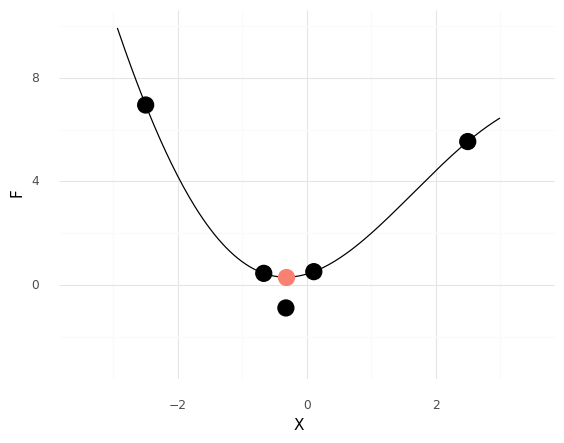

<ggplot: (8762287745034)>

In [21]:
## Minimize the fitted model
md_fit1 = (
    df_round1
    >> gr.ft_gp(
        var=["x"],
        out=["f"],
    )
    >> gr.cp_bounds(x=(-3, +3))
)
df_opt1 = (
    md_fit1
    >> gr.ev_min(
        out_min="f_mean",
    )
)
df_round2 = (
    df_round1
    >> gr.tf_bind_rows(
        md_multi
        >> gr.ev_df(df_opt1),
    )
)

## Vis
p = (
    df_round2
    >> gr.ggplot(gr.aes("x", "f"))
    
    + gr.geom_line(
        data=md_fit1
        >> gr.ev_df(df=gr.df_make(x=gr.linspace(-3, +3, 200))),
        mapping=gr.aes(y="f_mean"),
    )
    + gr.geom_point(
        data=df_opt1,
        mapping=gr.aes(y="f_mean"),
        size=6,
        color="salmon",
    )
    + gr.geom_point(size=6)
    
    + gr.scale_x_continuous(limits=(-3.5, +3.5))
    + gr.scale_y_continuous(limits=(-3.0, 10))
    + gr.theme_minimal()
    + gr.theme(panel_background=gr.element_rect(fill="white"))
    + gr.labs(
        x="X",
        y="F",
    )
)
p.save("./images/sdoe-round1-opt.png")
p

# Sequential DOE: Ternary space

Illustrate the sequential DOE (aka AL, aka BO) approach.


## Fit model, visualize contours


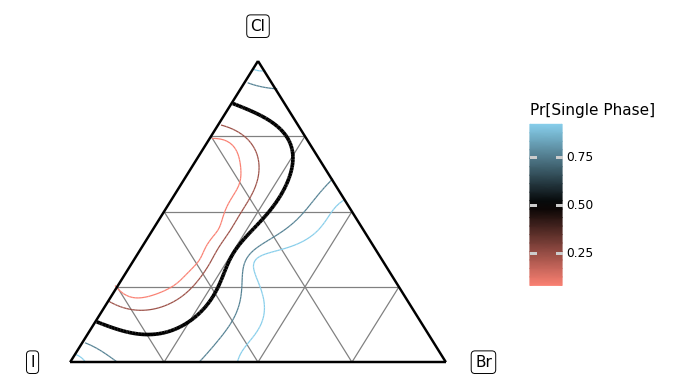

<ggplot: (8762361500642)>

In [22]:
## Fit using round2 [0, 1, 2] only
md_fit_round1 = (
    df_data
    >> gr.tf_filter(DF["round"] <= 2)
    >> tf_bary
    >> gr.ft_gp(
        out=["single_phase"],
        var=["x", "y"],
        kernels=dict(single_phase=Matern(length_scale=0.5, nu=0.5)), # continuous
        # kernels=dict(single_phase=Matern(length_scale=0.1, nu=1.5)), # once-differentiable
        # kernels=dict(single_phase=Matern(length_scale=0.5, nu=2.5)), # twice-differentiable
        # kernels=dict(single_phase=Matern(length_scale=0.5, nu=np.inf)), # infinitely-differentiable
        seed=103,
    )
)

## Assess via contours
df_contours1 = (
    md_fit_round1
    >> gr.cp_bounds(x=(0, 1), y=(0, 1))
    >> gr.ev_contour(
        out=["single_phase_mean"], 
        var=["x", "y"], 
        n_side=128,
        levels=dict(single_phase_mean=[0.1, 0.25, 0.5, 0.75, 0.9])
    )
    >> tf_thp()
    >> gr.tf_filter(
        0 <= DF.I,
        0 <= DF.Br,
        0 <= DF.Cl,
        DF.I <= 1,
        DF.Br <= 1,
        DF.Cl <= 1,
    )
)

p = (
    df_contours1
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Data
    + gr.geom_segment(
        gr.aes(xend="x_end", yend="y_end", color="level"), 
        size=0.5,
    )
    + gr.geom_segment(
        data=df_contours1
        >> gr.tf_filter(DF.level == 0.5),
        mapping=gr.aes(xend="x_end", yend="y_end", color="level"), 
        size=1.5,
    )
    # Triangle border
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    # Plot tail
    # + gr.scale_color_continuous(name="Pr[Single Phase]")
    + gr.scale_color_gradient2(
        name="Pr[Single Phase]",
        high="skyblue",
        mid="black",
        low="salmon",
        midpoint=0.5,
    )
    + gr.theme_void()
    + gr.theme(
        # legend_position="bottom",
        plot_background=gr.element_rect(fill="white")
    )
    
)
p.save("./images/ternary-cartoon-contours.png")
p

## Data and boundary


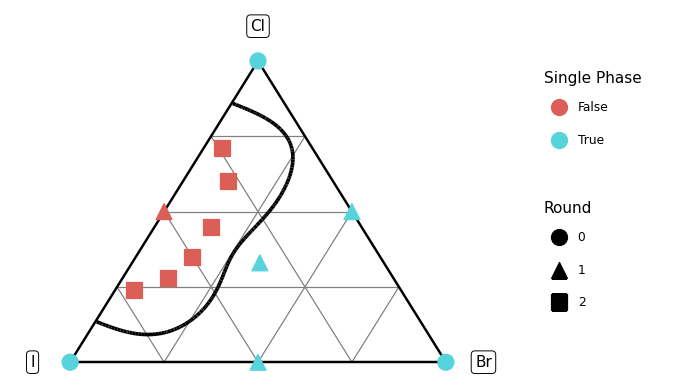

<ggplot: (8762287737546)>

In [23]:
p = (
    df_contours1
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Data
    + gr.geom_segment(
        data=df_contours1
        >> gr.tf_filter(DF.level == 0.5),
        mapping=gr.aes(xend="x_end", yend="y_end"), 
        size=1.5,
        color="black",
    )
    # Triangle border
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    # Data
    + gr.geom_point(
        data=df_data
        >> gr.tf_filter(DF["round"] <= 2)
        >> tf_bary(),
        mapping=gr.aes(color="single_phase", shape="factor(round)"), 
        size=6,
    )
    # Plot tail
    + gr.scale_color_discrete(name="Single Phase")
    + gr.scale_shape_discrete(name="Round")
    + gr.theme_void()
    + gr.theme(
        # legend_position="bottom",
        plot_background=gr.element_rect(fill="white")
    )
    
)
p.save("./images/ternary-cartoon-boundary.png")
p


In [24]:
df_contour50 = (
    md_fit_round1
    >> gr.cp_bounds(x=(0, 1), y=(0, 1))
    >> gr.ev_contour(
        out=["single_phase_mean"], 
        var=["x", "y"], 
        n_side=128,
        levels=dict(single_phase_mean=[0.5])
    )
    >> tf_thp()
    >> gr.tf_filter(
        0 <= DF.I,
        0 <= DF.Br,
        0 <= DF.Cl,
        DF.I <= 1,
        DF.Br <= 1,
        DF.Cl <= 1,
    )
)

df_sp = (
    df_contour50
    >> gr.tf_sp(
        n=6,
        var=["x", "y"],
        n_maxiter=1000,
        tol=1e-4,
    )
)

df_sp

tran_sp finished in 75 iterations with distance criterion 9.968e-05


,x,y
0,0.588666,0.561252
1,0.508102,0.708661
2,0.153009,0.087239
3,0.330601,0.128676
4,0.416953,0.275582
5,0.510827,0.410084


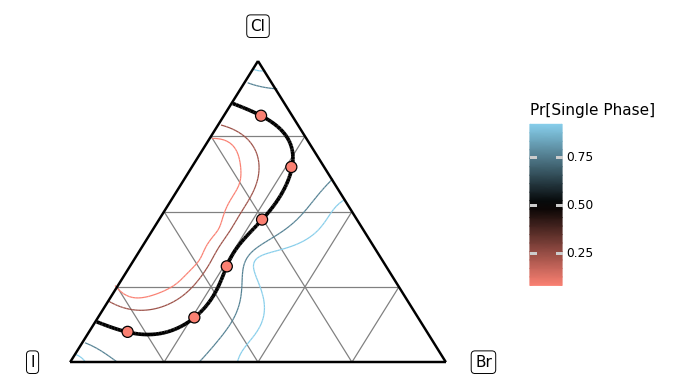

<ggplot: (8762338574424)>

In [25]:
p = (
    df_contours1
    >> gr.ggplot(gr.aes("x", "y"))
    # Guides
    + gr.geom_segment(
        data=df_tri_guides,
        mapping=gr.aes(xend="xend", yend="yend"),
        color="grey",
        size=0.5,
    )
    + gr.geom_label(
        data=df_tri_labels,
        mapping=gr.aes(label="label")
    )
    # Data
    + gr.geom_segment(
        gr.aes(xend="x_end", yend="y_end", color="level"), 
        size=0.5,
    )
    + gr.geom_segment(
        data=df_contours1
        >> gr.tf_filter(DF.level == 0.5),
        mapping=gr.aes(xend="x_end", yend="y_end", color="level"), 
        size=1.5
    )
    # Triangle border
    + gr.geom_segment(
        data=df_tri_bounds,
        mapping=gr.aes(xend="gr.lead(x)", yend="gr.lead(y)"),
        size=1.0,
    )
    # Candidate points
    + gr.geom_point(
        data=df_sp,
        size=4,
        fill="salmon",
        color="black",
    )
    # Plot tail
    # + gr.scale_color_continuous(name="Pr[Single Phase]")
    + gr.scale_color_gradient2(
        name="Pr[Single Phase]",
        high="skyblue",
        mid="black",
        low="salmon",
        midpoint=0.5,
    )
    + gr.theme_void()
    + gr.theme(
        # legend_position="bottom",
        plot_background=gr.element_rect(fill="white")
    )
    
)
p.save("./images/ternary-cartoon-candidates.png")
p
